In [1]:
import os
import glob
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/home/andres/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Temperature differences
df = pd.read_csv('./stations/diff.csv', delimiter=',')
df.head()

,station,temp_diff,lon,lat
0,70:ee:50:01:ad:68,0.843368,-5.999379,37.372700
1,70:ee:50:01:d9:c2,-0.004603,-6.064502,37.350200
2,70:ee:50:04:a4:52,2.106411,-5.953227,37.480981
3,70:ee:50:12:7b:c8,-0.904926,-6.031655,37.339592
4,70:ee:50:12:a7:10,0.513506,-6.037298,37.385381


In [3]:
import pyproj

# Define the CRS for the original (longitude, latitude) and target (projected coordinates)
wgs84 = pyproj.CRS("EPSG:4326")  # WGS84 (longitude, latitude)
utm = pyproj.CRS("EPSG:25830")  # UTM projection (ETRS89 / UTM zone 30N)

# Create a transformer to convert between the two coordinate systems
transformer = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True)

In [4]:
# Apply transformation to each row and modify the DataFrame
df['x'], df['y'] = zip(*df.apply(lambda row: transformer.transform(row['lon'], row['lat']), axis=1))
df.head()

,station,temp_diff,lon,lat,x,y
0,70:ee:50:01:ad:68,0.843368,-5.999379,37.372700,234403.047833,4.140440e+06
1,70:ee:50:01:d9:c2,-0.004603,-6.064502,37.350200,228553.831471,4.138129e+06
2,70:ee:50:04:a4:52,2.106411,-5.953227,37.480981,238867.540000,4.152328e+06
3,70:ee:50:12:7b:c8,-0.904926,-6.031655,37.339592,231426.205086,4.136858e+06
4,70:ee:50:12:a7:10,0.513506,-6.037298,37.385381,231089.801554,4.141955e+06


In [5]:
# Go to raster directory
raster_dir = './rasters'
os.chdir(raster_dir)

In [6]:
# List all .tif files
list = glob.glob('*.tif')
list

['GLI_scaled.tif',
 'SVF.tif',
 'NDTI_scaled.tif',
 'predictors_svf_gli.tif',
 'NBAI_scaled.tif',
 'average_blue.tif',
 'MDT_normalized_scaled.tif',
 'MDS.tif',
 'SVF_scaled.tif',
 'average_red.tif',
 'MDT_normalized.tif',
 'LST.tif',
 'average_green.tif',
 'LST_normalized_scaled.tif',
 'GLI.tif',
 'average_nir.tif',
 'average_swir2.tif',
 'NBAI.tif',
 'average_swir1.tif',
 'NDTI.tif',
 'MDT.tif',
 'LST_normalized.tif']

EPSG:25830


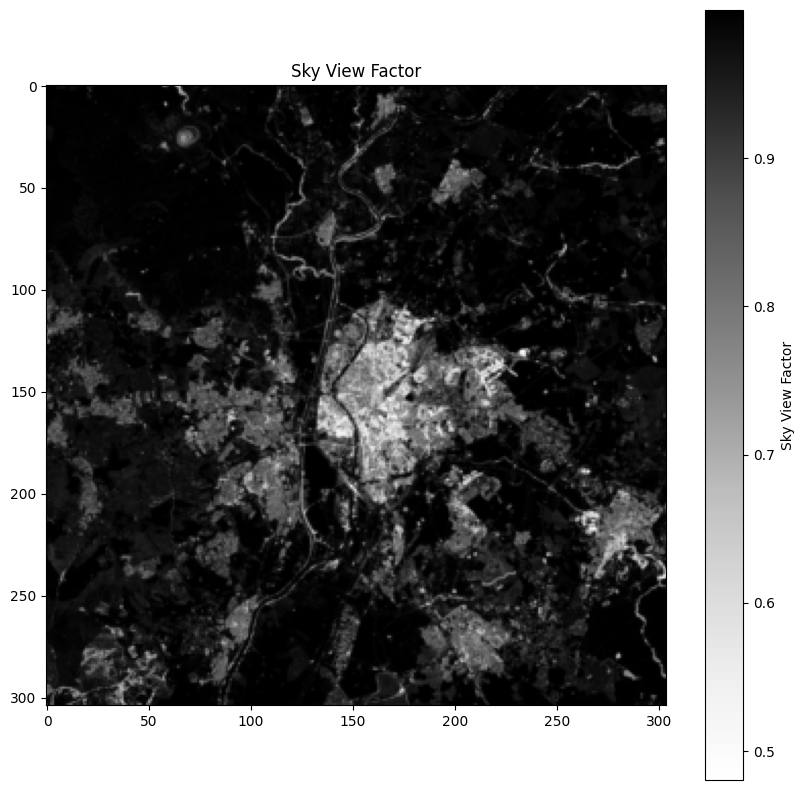

In [7]:
svf_raster_path = 'SVF_scaled.tif'
with rasterio.open(svf_raster_path) as src:
    print(src.crs)
    svf = src.read(1)

    # Extract coordinates for each pixel
    coords = np.array([src.transform * (col, row)
                       for row in range(src.height)
                       for col in range(src.width)])

    lons, lats = coords[:, 0], coords[:, 1]

    # Get SVF values
    svfs = []
    for index, station in df.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
        
        # Ensure the indices are within bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Read the value of the pixel
            svf_value = svf[row, col]
            svfs.append(svf_value)
        else:
            # Handle out-of-bounds cases
            print(f"Warning: Coordinates ({station['lon']}, {station['lat']}) are out of bounds.")
            svfs.append(np.nan) # Append NaN for out-of-bounds
    df['svf'] = svfs
    
    
plt.figure(figsize=(10, 10))
plt.imshow(svf, cmap='Grays')
plt.colorbar(label='Sky View Factor')
plt.title(f'Sky View Factor')
plt.show()

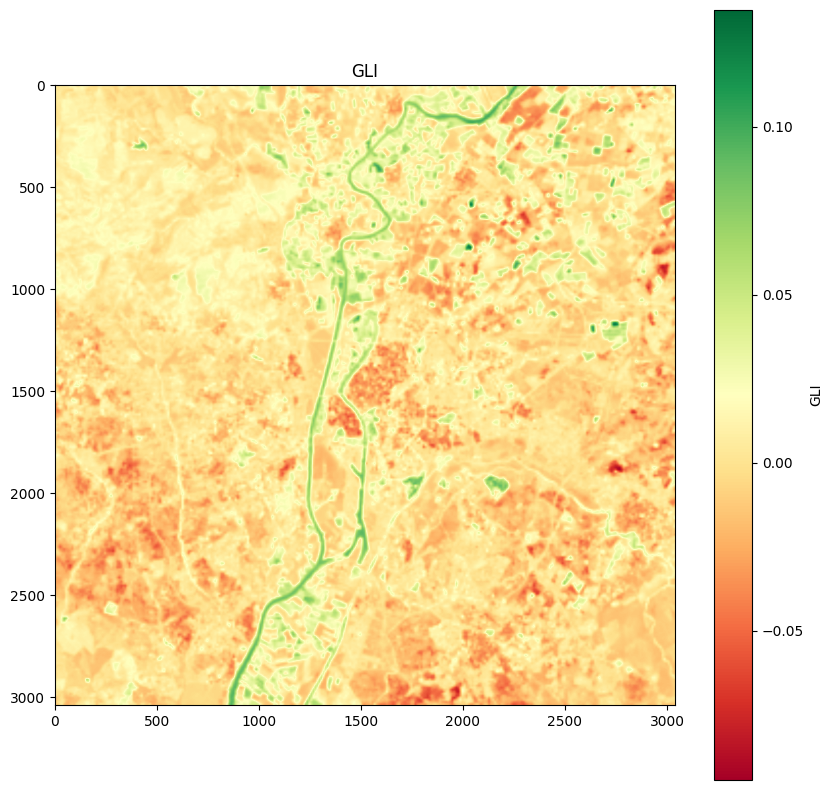

In [8]:
gli_raster_path = 'GLI_scaled.tif'
with rasterio.open(gli_raster_path) as src:
    gli = src.read(
        out_shape=(
            src.count,
            int(3039),
            int(3039)
        ),
        resampling = Resampling.bilinear
    )[0]

    # Get NDVI values
    glis = []
    for index, station in df.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
    
        # Ensure the indices are within bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Read the value of the pixel
            gli_value = gli[row, col]
            glis.append(gli_value)
        else:
            # Handle out-of-bounds cases
            print(f"Warning: Coordinates ({station['lon']}, {station['lat']}) are out of bounds.")
            glis.append(np.nan)  # Append NaN for out-of-bounds
    df['gli'] = glis
    
plt.figure(figsize=(10, 10))
plt.imshow(gli, cmap='RdYlGn')
plt.colorbar(label='GLI')
plt.title(f'GLI')
plt.show()

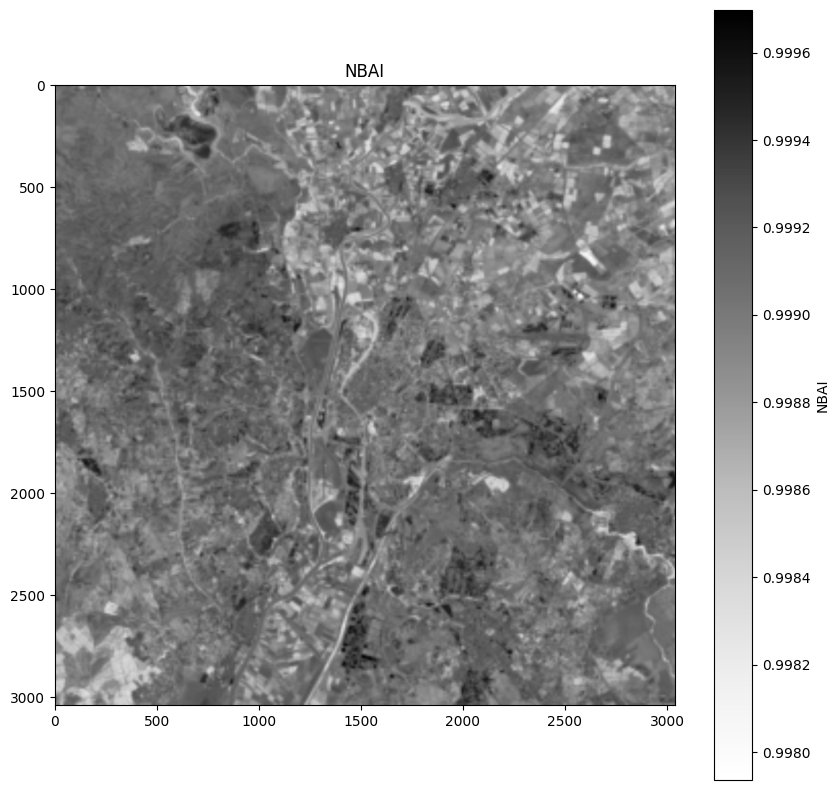

In [9]:
nbai_raster_path = 'NBAI_scaled.tif'
with rasterio.open(nbai_raster_path) as src:
    nbai = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]

    # Get NBAI values
    nbais = []
    for index, station in df.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
        
        # Ensure the indices are within bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Read the value of the pixel
            nbai_value = nbai[row, col]
            nbais.append(nbai_value)
        else:
            # Handle out-of-bounds cases
            print(f"Warning: Coordinates ({station['lon']}, {station['lat']}) are out of bounds.")
            nbais.append(np.nan)  # Append NaN for out-of-bounds
    df['nbai'] = nbais
    
plt.figure(figsize=(10, 10))
plt.imshow(nbai, cmap='Grays')
plt.colorbar(label='NBAI')
plt.title(f'NBAI')
plt.show()

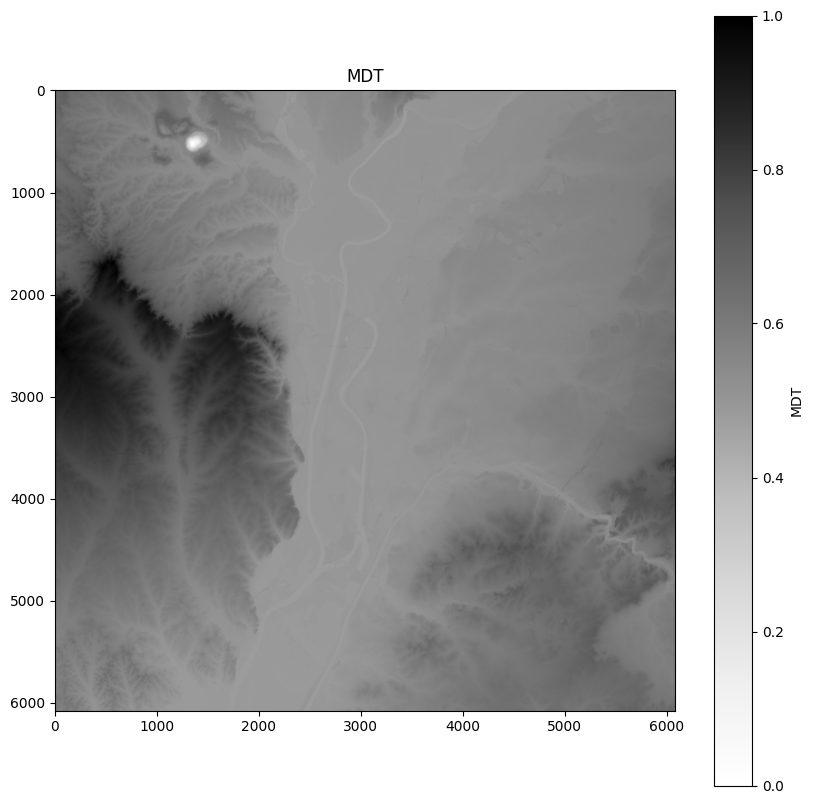

In [10]:
mdt_raster_path = 'MDT_normalized_scaled.tif'
with rasterio.open(mdt_raster_path) as src:
    '''mdt = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]'''
    mdt = src.read(1)

    # Get MDT values
    mdts = []
    for index, station in df.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])

        #print(mdt.shape)
        #print(f"Row: {row}, Col: {col}")
        
        # Ensure the indices are within bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Read the value of the pixel
            mdt_value = mdt[row, col]
            mdts.append(mdt_value)
        else:
            # Handle out-of-bounds cases
            print(f"Warning: Coordinates ({station['lon']}, {station['lat']}) are out of bounds.")
            mdts.append(np.nan)  # Append NaN for out-of-bounds
    df['mdt'] = mdts
    
plt.figure(figsize=(10, 10))
plt.imshow(mdt, cmap='Grays')
plt.colorbar(label='MDT')
plt.title(f'MDT')
plt.show()

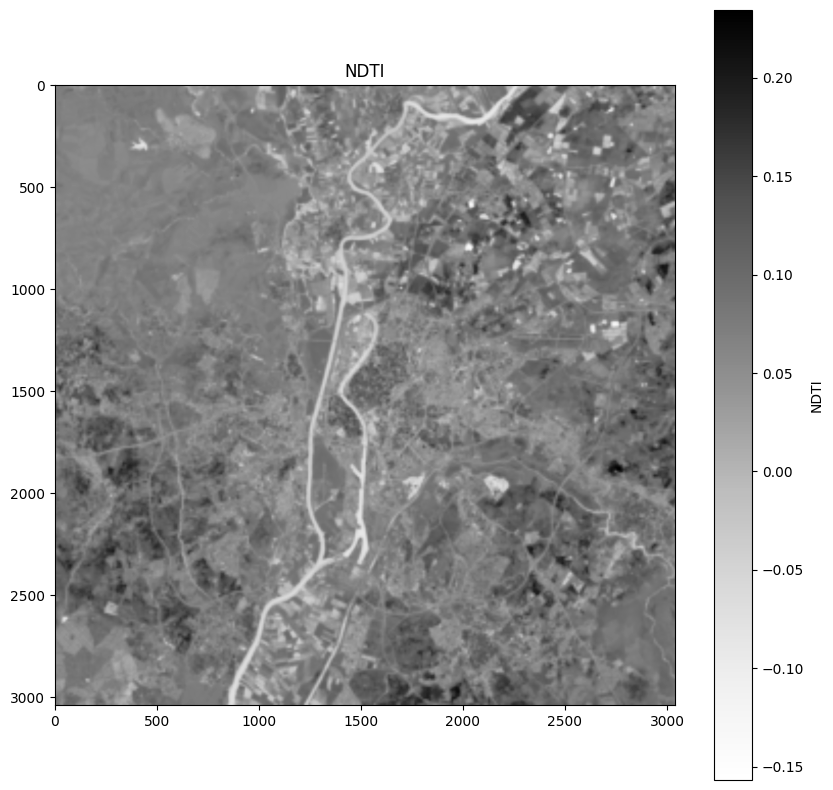

In [11]:
ndti_raster_path = 'NDTI_scaled.tif'
with rasterio.open(ndti_raster_path) as src:
    ndti = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]

    # Get NDTI values
    ndtis = []
    for index, station in df.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
        
        # Ensure the indices are within bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Read the value of the pixel
            ndti_value = ndti[row, col]
            ndtis.append(ndti_value)
        else:
            # Handle out-of-bounds cases
            print(f"Warning: Coordinates ({station['lon']}, {station['lat']}) are out of bounds.")
            ndtis.append(np.nan)  # Append NaN for out-of-bounds
    df['ndti'] = ndtis
    
plt.figure(figsize=(10, 10))
plt.imshow(ndti, cmap='Grays')
plt.colorbar(label='NDTI')
plt.title(f'NDTI')
plt.show()

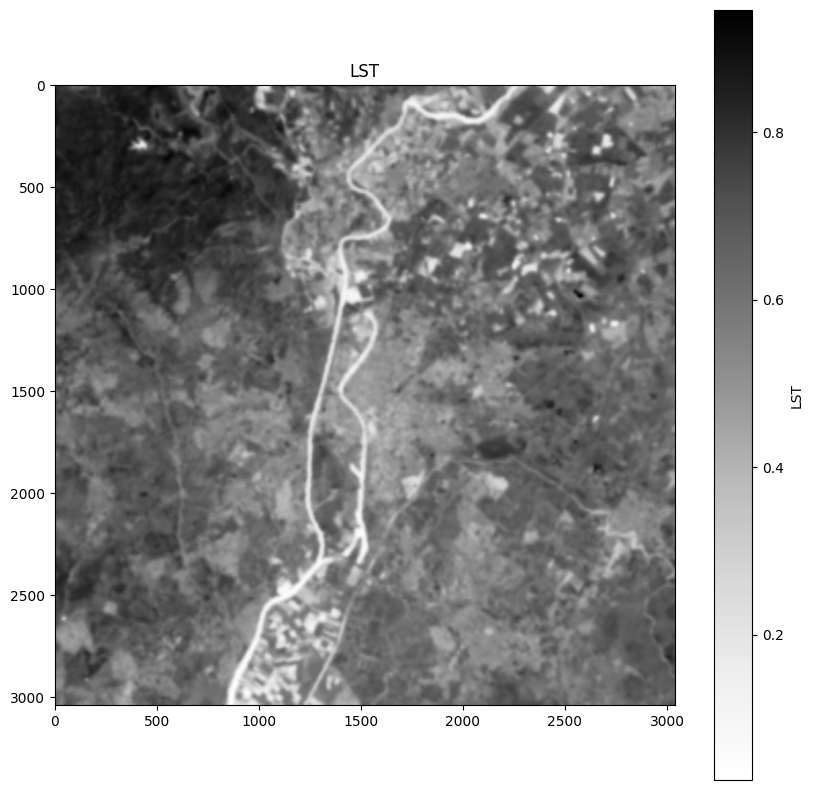

In [12]:
lst_raster_path = 'LST_normalized_scaled.tif'
with rasterio.open(lst_raster_path) as src:
    lst = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]

    # Get LST values
    lsts = []
    for index, station in df.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
        
        # Ensure the indices are within bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Read the value of the pixel
            lst_value = lst[row, col]
            lsts.append(lst_value)
        else:
            # Handle out-of-bounds cases
            print(f"Warning: Coordinates ({station['lon']}, {station['lat']}) are out of bounds.")
            lsts.append(np.nan)  # Append NaN for out-of-bounds
    df['lst'] = lsts
    
plt.figure(figsize=(10, 10))
plt.imshow(lst, cmap='Grays')
plt.colorbar(label='LST')
plt.title(f'LST')
plt.show()

In [13]:
df.head()

,station,temp_diff,lon,lat,x,y,svf,gli,nbai,mdt,ndti,lst
0,70:ee:50:01:ad:68,0.843368,-5.999379,37.372700,234403.047833,4.140440e+06,0.562542,0.004595,0.999065,0.495501,0.072988,0.854795
1,70:ee:50:01:d9:c2,-0.004603,-6.064502,37.350200,228553.831471,4.138129e+06,0.843560,0.016501,0.999107,0.694408,0.059785,0.835400
2,70:ee:50:04:a4:52,2.106411,-5.953227,37.480981,238867.540000,4.152328e+06,0.887167,0.004380,0.999104,0.513304,0.068282,0.785873
3,70:ee:50:12:7b:c8,-0.904926,-6.031655,37.339592,231426.205086,4.136858e+06,0.829317,0.018979,0.999066,0.653283,0.057000,0.845872
4,70:ee:50:12:a7:10,0.513506,-6.037298,37.385381,231089.801554,4.141955e+06,0.852523,0.010108,0.999087,0.641366,0.067357,0.844635


In [14]:
df = df.drop(columns=['x', 'y'])
df.head()

,station,temp_diff,lon,lat,svf,gli,nbai,mdt,ndti,lst
0,70:ee:50:01:ad:68,0.843368,-5.999379,37.372700,0.562542,0.004595,0.999065,0.495501,0.072988,0.854795
1,70:ee:50:01:d9:c2,-0.004603,-6.064502,37.350200,0.843560,0.016501,0.999107,0.694408,0.059785,0.835400
2,70:ee:50:04:a4:52,2.106411,-5.953227,37.480981,0.887167,0.004380,0.999104,0.513304,0.068282,0.785873
3,70:ee:50:12:7b:c8,-0.904926,-6.031655,37.339592,0.829317,0.018979,0.999066,0.653283,0.057000,0.845872
4,70:ee:50:12:a7:10,0.513506,-6.037298,37.385381,0.852523,0.010108,0.999087,0.641366,0.067357,0.844635


In [15]:
# Drop NaNs
df = df.dropna()
df.head()

,station,temp_diff,lon,lat,svf,gli,nbai,mdt,ndti,lst
0,70:ee:50:01:ad:68,0.843368,-5.999379,37.372700,0.562542,0.004595,0.999065,0.495501,0.072988,0.854795
1,70:ee:50:01:d9:c2,-0.004603,-6.064502,37.350200,0.843560,0.016501,0.999107,0.694408,0.059785,0.835400
2,70:ee:50:04:a4:52,2.106411,-5.953227,37.480981,0.887167,0.004380,0.999104,0.513304,0.068282,0.785873
3,70:ee:50:12:7b:c8,-0.904926,-6.031655,37.339592,0.829317,0.018979,0.999066,0.653283,0.057000,0.845872
4,70:ee:50:12:a7:10,0.513506,-6.037298,37.385381,0.852523,0.010108,0.999087,0.641366,0.067357,0.844635


In [16]:
df.to_csv('../data_netatmo.csv', index=False)